In [17]:
import glob
import numpy as np
import matplotlib.pyplot as plt

import sys
import csky as cy
import os
import photospline as psp
from csky import cext
import time
from csky import hyp
import copy

trialfile_dir = '/data/user/wluszczak/KDE_csky/reproducibility/ntv5/'

In [2]:
def GreatCircleDistance(ra_1, dec_1, ra_2, dec_2):
        '''Compute the great circle distance between two events'''
        '''All coordinates must be given in radians'''
        delta_dec = np.abs(dec_1 - dec_2)
        delta_ra = np.abs(ra_1 - ra_2)
        x = (np.sin(delta_dec / 2.))**2. + np.cos(dec_1) *\
            np.cos(dec_2) * (np.sin(delta_ra / 2.))**2.
        return 2. * np.arcsin(np.sqrt(x))

def spatial_kde(log_psi, log_ang_err, log_energy, gamma):
    return spatial_pdf.evaluate_simple([log_ang_err, log_energy, log_psi, np.full(len(log_psi), gamma)], 0)

def energy_kde(log_energy, src_dec, gamma):
    sin_src_dec = np.sin(src_dec)
    return energy_pdf.evaluate_simple([log_energy, np.full(len(log_energy), sin_src_dec), np.full(len(log_energy), gamma)], 0)

def calc_sb_ratio(ev_ra, ev_dec, ev_angErr, ev_logE, src, gamma, **kwargs):
    if '_mask' in kwargs:
        #print("there is a mask")
        mask = kwargs['_mask']
        antimask = mask[mask==False]
        src_ra = src['ra']
        src_dec = src['dec']

        ev_ra_mask = ev_ra[mask]
        ev_dec_mask = ev_dec[mask]
        ev_angErr_mask = ev_angErr[mask]
        ev_logE_mask = ev_logE[mask]

        psi = GreatCircleDistance(ev_ra_mask, ev_dec_mask, src_ra, src_dec)
        #cpsi = cext.get_dpsis_by_sigmas_for_space_pdf(ev_dec, ev_ra, ev_angErr, src_dec, src_ra, np.zeros(np.shape(src_ra)), 5.)

        log_psi = np.log10(psi)
        log_ang_err = np.log10(ev_angErr_mask)
        log_energy = ev_logE_mask
        masked_ev_dec = ev_dec_mask

#        print("evaluating calc_sb_ratio over", len(log_psi), "events")

        spdfs = spatial_kde(log_psi, log_ang_err, log_energy, gamma)
        spatial_norm = np.log(10) * psi * np.sin(psi)
        spdfs/= spatial_norm

        epdfs = energy_kde(log_energy, src_dec, gamma)

        bg_pdfs = bkg_pdf.evaluate_simple([log_energy, np.sin(masked_ev_dec)])
        sb_ratio_close = spdfs*epdfs/bg_pdfs

        far_evts_sb = np.zeros(len(antimask))
        #sb_ratio = np.concatenate([sb_ratio, far_evts_sb])
        sb_ratio = np.zeros(len(ev_ra))
        sb_ratio[mask] = sb_ratio_close
    else:
        src_ra = src['ra']
        src_dec = src['dec']
        psi = GreatCircleDistance(ev_ra, ev_dec, src_ra, src_dec)
        #cpsi = cext.get_dpsis_by_sigmas_for_space_pdf(ev_dec, ev_ra, ev_angErr, src_dec, src_ra, np.zeros(np.shape(src_ra)), 5.)

        log_psi = np.log10(psi)
        log_ang_err = np.log10(ev_angErr)
        log_energy = ev_logE
        masked_ev_dec = ev_dec

        #print("evaluating calc_sb_ratio over", len(log_psi), "events")

        spdfs = spatial_kde(log_psi, log_ang_err, log_energy, gamma)
        spatial_norm = np.log(10) * psi* np.sin(psi)
        spdfs/= spatial_norm

        epdfs = energy_kde(log_energy, src_dec, gamma)

        bg_pdfs = bkg_pdf.evaluate_simple([log_energy, np.sin(masked_ev_dec)])
        sb_ratio = spdfs*epdfs/bg_pdfs

        #far_evts_sb = np.zeros(len(antimask))
        #sb_ratio = np.concatenate([sb_ratio, far_evts_sb])

    return sb_ratio

def dist_mask(arr, src, cut_deg):
    out = np.zeros(len(arr), dtype=bool)
    ras = arr['ra']
    decs = arr['dec']
    psi = GreatCircleDistance(ras, decs, src.ra, src.dec)
    out = psi < np.radians(cut_deg)
    return out


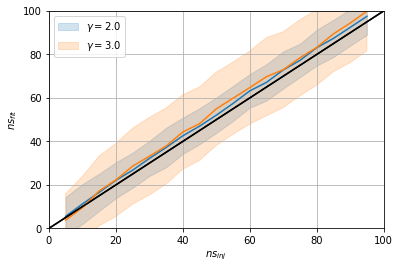

In [11]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'm']

i = 0
for gamma in [2.0, 3.0]:
    ns_fits = []
    ns_upper = []
    ns_lower = []
    nss = np.arange(5.0,100.0,5.0)
    for ns in nss:
        flist = glob.glob('tint_fitbias_%s_%s*.npy'%(ns, gamma))
        data = np.load(flist[0], allow_pickle=True)
        trialfits = [f[50579430] for f in data]
        trialfits = np.array(trialfits)
        tdata = np.transpose(trialfits)
        ts = tdata[0]
        ns_fit = tdata[1]
        gamma_fit = tdata[2]

        std = np.std(ns_fit)
        ns_avg = np.median(ns_fit)

        ns_fits.append(ns_avg)
        ns_upper.append(ns_avg+std)
        ns_lower.append(ns_avg-std)

    plt.plot(nss, ns_fits, color=colors[i])
    plt.fill_between(nss, ns_lower, ns_upper, color=colors[i], alpha=0.2, label='$\gamma=%s$'%(gamma))

    plt.plot([0,100], [0,100], 'k-')
    plt.xlim(0,100)
    plt.ylim(0,100)
    plt.xlabel('$ns_{inj}$')
    plt.ylabel('$ns_{fit}$')
    i+=1
plt.grid()
plt.legend()

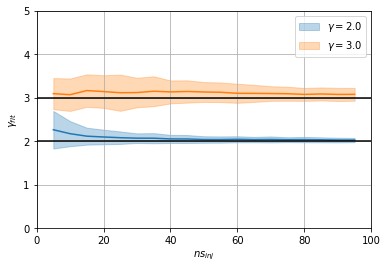

In [16]:
gamma = 2.0
gam_fits = []
gam_upper = []
gam_lower = []
nss = np.arange(5.0,100.0,5.0)
for ns in nss:
    flist = glob.glob('tint_fitbias_%s_%s*.npy'%(ns, gamma))
    data = np.load(flist[0], allow_pickle=True)
    trialfits = [f[50579430] for f in data]
    trialfits = np.array(trialfits)
    tdata = np.transpose(trialfits)
    ts = tdata[0]
    ns_fit = tdata[1]
    gamma_fit = tdata[2]
    
    std = np.std(gamma_fit)
    gam_avg = np.average(gamma_fit)
    
    gam_fits.append(gam_avg)
    gam_upper.append(gam_avg+std)
    gam_lower.append(gam_avg-std)

plt.plot(nss, gam_fits, color='tab:blue')
plt.fill_between(nss, gam_lower, gam_upper, color='tab:blue', alpha=0.3, label='$\gamma=2.0$')

plt.plot([0,100], [gamma,gamma], 'k-')

gamma = 3.0
gam_fits = []
gam_upper = []
gam_lower = []
nss = np.arange(5.0,100.0,5.0)
for ns in nss:
    flist = glob.glob('tint_fitbias_%s_%s*.npy'%(ns, gamma))
    data = np.load(flist[0], allow_pickle=True)
    trialfits = [f[50579430] for f in data]
    trialfits = np.array(trialfits)
    tdata = np.transpose(trialfits)
    ts = tdata[0]
    ns_fit = tdata[1]
    gamma_fit = tdata[2]
    
    std = np.std(gamma_fit)
    gam_avg = np.average(gamma_fit)
    
    gam_fits.append(gam_avg)
    gam_upper.append(gam_avg+std)
    gam_lower.append(gam_avg-std)

plt.plot(nss, gam_fits, color='tab:orange')
plt.fill_between(nss, gam_lower, gam_upper, color='tab:orange', alpha=0.3, label='$\gamma=3.0$')

plt.plot([0,100], [gamma,gamma], 'k-')
plt.xlim(0,100)
plt.ylim(0,5)
plt.grid()
plt.xlabel('$ns_{inj}$')
plt.ylabel('$\gamma_{fit}$')
plt.legend(loc=0)

[2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 18.0] [ 5.72177673  5.85536291  6.76357701  8.63674946 10.51037951 12.42748044
 14.51721615 18.06007792]


Text(0.5,1,'dT=20 days, $\\gamma=2.0$')

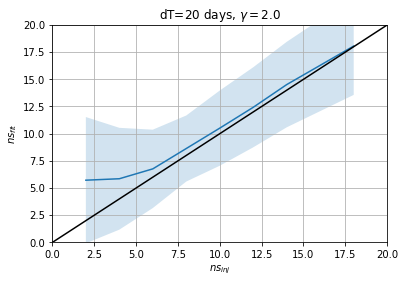

In [22]:
import glob

ns_fit = []
ns_inj = []
ns_err = []
for ns in np.arange(2.0, 20.0, 2.0):
    try:
        f = glob.glob(trialfile_dir+'ntv5_sigtrials_%s_ns.npy'%(ns))
        data = np.load(f[0], allow_pickle=True)
        all_ns = []
        for d in data:
            all_ns.append(d['ns'][0])
        med_ns = np.median(all_ns)
        ns_fit.append(med_ns)
        ns_inj.append(ns)
        ns_err.append(np.std(all_ns))
        
    except IndexError:
        pass
    
ns_fit = np.array(ns_fit)
ns_err = np.array(ns_err)
print(ns_inj, ns_fit)
plt.plot(ns_inj, ns_fit)
plt.fill_between(ns_inj, ns_fit-ns_err, ns_fit+ns_err, alpha=0.2)

plt.plot([0,100], [0,100], 'k-')
plt.xlim(0,20)
plt.ylim(0,20)
plt.grid()
plt.xlabel('$ns_{inj}$')
plt.ylabel('$ns_{fit}$')

plt.title('dT=20 days, $\gamma=2.0$')

[2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 18.0, 20.0] [2.64448362 2.1758767  2.09603269 2.05137232 2.02914541 2.00469411
 2.03478521 2.01573649        nan]


Text(0.5,1,'dT=20 days, $\\gamma=2.0$')

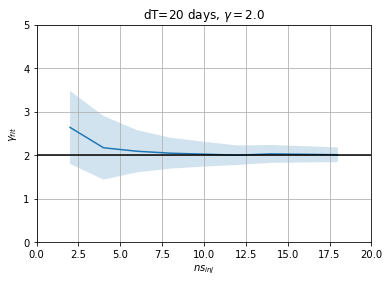

In [19]:
import glob

ns_fit = []
ns_inj = []
ns_err = []
for ns in np.arange(2.0, 30.0, 2.0):
    try:
        f = glob.glob(trialfile_dir+'ntv5_sigtrials_%s_ns.npy'%(ns))
        data = np.load(f[0], allow_pickle=True)
        all_ns = []
        for d in data:
            all_ns.append(d['gamma'][0])
        med_ns = np.median(all_ns)
        ns_fit.append(med_ns)
        ns_inj.append(ns)
        ns_err.append(np.std(all_ns))
        
    except IndexError:
        pass
    
ns_fit = np.array(ns_fit)
ns_err = np.array(ns_err)
print(ns_inj, ns_fit)
plt.plot(ns_inj, ns_fit)
plt.fill_between(ns_inj, ns_fit-ns_err, ns_fit+ns_err, alpha=0.2)

plt.plot([0,20],[2,2], 'k-')
plt.xlim(0,20)
plt.ylim(0,5)
plt.grid()
plt.xlabel('$ns_{inj}$')
plt.ylabel('$\gamma_{fit}$')

plt.title('dT=20 days, $\gamma=2.0$')


[2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 18.0, 20.0] [14.34383876  7.65092103  7.3305221   8.14736173  8.41404081  8.6018979
  8.83486667  9.07894834         nan] [101.32781028  66.32783179  40.41742912  23.72006064  18.74906691
   2.79928697   2.76947534   1.53515745          nan]


Text(0.5,1,'dT=10 days, $\\gamma=2.0$')

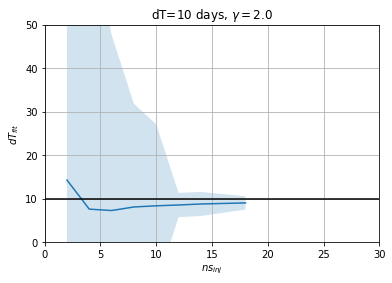

In [20]:
import glob

ns_fit = []
ns_inj = []
ns_err = []
for ns in np.arange(2.0, 30.0, 2.0):
    try:
        f = glob.glob(trialfile_dir+'ntv5_sigtrials_%s_ns.npy'%(ns))
        data = np.load(f[0], allow_pickle=True)
        all_ns = []
        for d in data:
            all_ns.append(d['tstop'][0]-d['tstart'][0])
        med_ns = np.median(all_ns)
        ns_fit.append(med_ns)
        ns_inj.append(ns)
        ns_err.append(np.std(all_ns))

        
    except IndexError:
        pass
    
ns_fit = np.array(ns_fit)
ns_err = np.array(ns_err)
print(ns_inj, ns_fit, ns_err)
plt.plot(ns_inj, ns_fit)
plt.fill_between(ns_inj, ns_fit-ns_err, ns_fit+ns_err, alpha=0.2)

plt.plot([0,30], [10,10], 'k-')
plt.xlim(0,30)
plt.ylim(0,50)

plt.grid()
plt.xlabel('$ns_{inj}$')
plt.ylabel('$dT_{fit}$')

plt.title('dT=10 days, $\gamma=2.0$')

[2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 18.0, 20.0] [56994.73606728 57017.91560996 57018.08269141 57017.76171065
 57017.62772001 57017.57328775 57017.53509949 57017.36221053
            nan] [4.39700096e+03 5.07669213e+03 2.54920960e+03 6.76741785e+01
 5.68616591e+01 3.78034388e+01 2.61842015e+00 8.35069925e-01
            nan]


Text(0.5,1,'$T_0$ = 57017.01, dT=10 days, $\\gamma=2.0$')

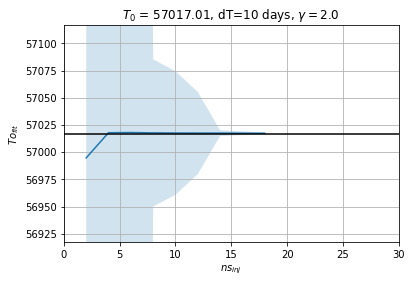

In [21]:
import glob

ns_fit = []
ns_inj = []
ns_err = []
for ns in np.arange(2.0, 30.0, 2.0):
    try:
        f = glob.glob(trialfile_dir+'ntv5_sigtrials_%s_ns.npy'%(ns))
        data = np.load(f[0], allow_pickle=True)
        all_ns = []
        for d in data:
            all_ns.append(d['tstart'][0])
        med_ns = np.median(all_ns)
        ns_fit.append(med_ns)
        ns_inj.append(ns)
        ns_err.append(np.std(all_ns))

        
    except IndexError:
        pass
    
ns_fit = np.array(ns_fit)
ns_err = np.array(ns_err)
print(ns_inj, ns_fit, ns_err)
plt.plot(ns_inj, ns_fit)
plt.fill_between(ns_inj, ns_fit-ns_err, ns_fit+ns_err, alpha=0.2)

#plt.plot([0,30], [20,20], 'k-')
plt.axhline(57017.01, color='k')
plt.xlim(0,30)
plt.ylim(57017.01-100,57017.01+100)

plt.grid()
plt.xlabel('$ns_{inj}$')
plt.ylabel('$To_{fit}$')

plt.title('$T_0$ = 57017.01, dT=10 days, $\gamma=2.0$')